# Global to local optimisation

Compare global and local solutions to generic DEMO, and try to "polish" a global solution.

In [1]:
# Reload Process each time (keep editable install up-to-date)
%load_ext autoreload
%autoreload 2

from process.io import plot_solutions as ps
from pathlib import Path
import process

Plot the local VMCON solution for the generic DEMO IN.DAT (with f-values) against the global ISRES solution (no f-values). VMCON soln has 47 iter vars due to f-values, ISRES soln has 23 due to no f-values. Mis-match causes only 23 in common to be plotted: others are listed as NaNs.

/home/jon/code/process/process/io/plot_solutions.py:801: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  norm_objf_values_df = norm_objf_values_df["norm_objf"].mul(-1)


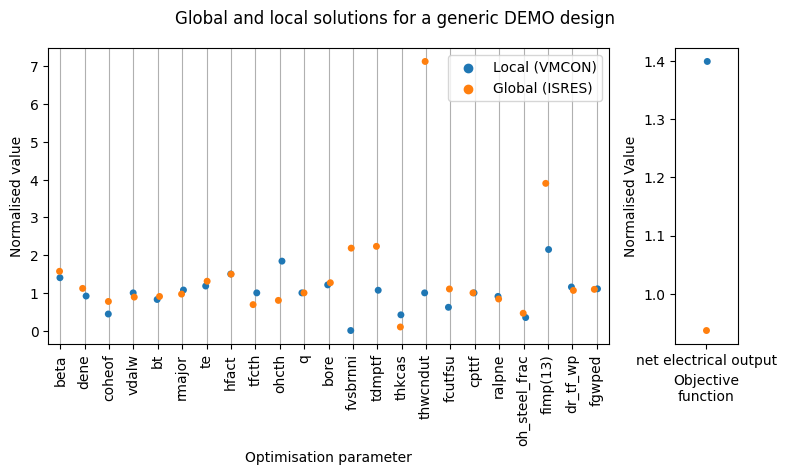

In [41]:
# Define data location
isres_mfile_path = Path("../isres_no_f_values") / "1e-5_1e6_MFILE.DAT"
vmcon_mfile = Path("../demo_vmcon_MFILE.DAT")

# Mfiles and tags for each run to be plotted
runs_metadata = [
    ps.RunMetadata(vmcon_mfile, "Local (VMCON)"),
    ps.RunMetadata(isres_mfile_path, "Global (ISRES)"),
]

# Plot global solutions compared to VMCON
isres_vmcon_solns, ax = ps.plot_mfile_solutions(
    runs_metadata,
    "Global and local solutions for a generic DEMO design",
    diff_factor=False,
    relative_tag=None,
    drop_f_values=False,
    plot_itvars=False,
)

legend = ax[0].legend()
legend.set_title(None)

Plotted both sets of normalised itvars (normalised to same initial point). Shows how both solns differ to the initial point. Plot the percentage differences:

Percentages won't work yet, as different numbers of iter vars. Need to put a fix in if I want this. Don't bother: above plot is more descriptive.

In [47]:
# Plot global solutions compared to VMCON
isres_vmcon_solns = ps.plot_mfile_solutions(
    runs_metadata,
    "Generic DEMO global solution relative to local solution",
    diff_factor=True,
    relative_tag=None,
    drop_f_values=False,
    plot_itvars=False,
)

IndexError: list index out of range

In [48]:
isres_vmcon_solns

,tag,objf_name,norm_objf,itvar001_name,xcm001,itvar002_name,xcm002,itvar003_name,xcm003,itvar004_name,...,itvar043_name,xcm043,itvar044_name,xcm044,itvar045_name,xcm045,itvar046_name,xcm046,itvar047_name,xcm047
0,Local (VMCON),net electrical output,-1.39920,beta,1.4016,dene,0.91623,fwalld,0.42998,ffuspow,...,ralpne,0.90682,oh_steel_frac,0.34628,fimp(13),2.1491,dr_tf_wp,1.1558,fgwped,1.1077
1,Global (ISRES),net electrical output,-0.93691,beta,1.5716,dene,1.11850,coheof,0.77259,vdalw,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Global to local

This is a slightly wild solution (very low constraint tolerances), but nevertheless a good starting point. We want to use the output MFILE from the global solver (plotted above) as an IN.DAT for the local solver.

First, extract the solution (optimisation parameters) from the global optimisation.

In [49]:
from process.io.mfile import MFile
from process.io.in_dat import InDat

# Create Mfile object from global solution
mfile = MFile(isres_mfile_path)

# Get number of optimisation parameters
n = int(mfile.data["nvar"].get_scan(-1))

# Get all n optimisation parameter names and values from "itvarxxx" number
opt_params = {}
for i in range(n):
    opt_param_no = f"itvar{i+1:03}"
    param_name = mfile.data[opt_param_no].var_description
    param_value = mfile.data[opt_param_no].get_scan(-1)
    opt_params[param_name] = param_value

# Print optimisation parameters at global solution
print(f"Global solution = {opt_params}")

Global solution = {'beta': 0.04938, 'dene': 8.3129e+19, 'coheof': 15993000.0, 'vdalw': 8.8826, 'bt': 5.1596, 'rmajor': 8.7108, 'te': 16.139, 'hfact': 1.1966, 'tfcth': 0.96427, 'ohcth': 0.40045, 'q': 3.0, 'bore': 2.9558, 'fvsbrnni': 0.86548, 'tdmptf': 57.68, 'thkcas': 0.050439, 'thwcndut': 0.057059, 'fcutfsu': 0.89246, 'cpttf': 65017.0, 'ralpne': 0.083815, 'oh_steel_frac': 0.36785, 'fimp(13)': 0.0014827, 'dr_tf_wp': 0.53257, 'fgwped': 0.71054}


Now overwrite the original input file with that global solution as the initial optimisation parameters.

In [51]:
# Now read in original IN.DAT
in_dat_path = Path("../no_f_values_demo_IN.DAT")
in_dat = InDat(in_dat_path)

# Change to the new optimisation parameter values
for var_name, value in opt_params.items():
    in_dat.add_parameter(var_name, value)

# Write out new IN.DAT, with optimisation parameters set to global solution
new_in_dat_path = Path("local_IN.DAT")
in_dat.write_in_dat(new_in_dat_path)

## Running the local optimisation

The local optimisation can now be attempted from the global solution.

VMCON doesn't converge, and neither does scipy. Try agian with much higher tolerances:

In [52]:
single_run = process.main.SingleRun(str(new_in_dat_path), solver_config="solver.toml")
single_run.run()

The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-963-gcda1a8011 code contains untracked changes
    Branch : nlopt-soln-plotting
   Git log : Use iter var bounds in input.f90
 Date/time : 23 May 2023 10:28:08 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-P

/home/jon/.local/lib/python3.10/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Evaluation 501, objective function = -1.7692, constraint residuals = 1.373e+01
Evaluation 502, objective function = -1.7706, constraint residuals = 1.373e+01
Evaluation 503, objective function = -1.7712, constraint residuals = 1.373e+01
Evaluation 504, objective function = -1.7715, constraint residuals = 1.373e+01
Evaluation 505, objective function = -1.7716, constraint residuals = 1.373e+01
Evaluation 506, objective function = -1.7717, constraint residuals = 1.373e+01
Evaluation 507, objective function = -1.7717, constraint residuals = 1.373e+01
Evaluation 508, objective function = -1.7717, constraint residuals = 1.373e+01
Evaluation 509, objective function = -1.7718, constraint residuals = 1.373e+01
Evaluation 510, objective function = -1.7718, constraint residuals = 1.373e+01
Evaluation 511, objective function = -1.7718, constraint residuals = 1.373e+01
Evaluation 512, objective function = -1.7715, constraint residuals = 1.373e+01
Evaluation 513, objective function = -1.7727, constr

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance for reactor is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance for power plant is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
150     2   CHECK: Lower limit of volume averaged electron temperature (te) has been raised 
  
132     2   DOOPT: Optimisation solver VMCON returns with ifail /= 1                        
 Integer diagnostic values for this error:
   1)              2
  
 87     2   OUTPLAS: Possible problem with high radiation power, forcing pdivt to odd values
 Floating point diagnostic values for this error:
   1)    1.00000E-03
  
 93     2   BURN: Negative burn time available; reduce theat or raise PF coil V-s capability
 Floating point diagnostic values for this error:
   1)   -1.00000E+01
   2)   -0.00000E+00
   3)    5.20360E-03
   4)    1.00000E+01
  
 62     1   RADIALB: Ripple result may be inaccurate, as the fit has been extrapolated      
  
141     1   RADIALB: (TF coil ripple c

In [ ]:
# Plot global and local solution on same plot

# Define data location
vmcon_run_dir = Path("/home/jon/data/process/baseline2017/original")
isres_run_dir = Path("/home/jon/data/process/baseline2017/numevals_isres_1e-3_tol")

mfile_name = "baseline_2017_MFILE.DAT"

# Mfiles and tags for each run to be plotted
runs_metadata = [
    ps.RunMetadata(vmcon_run_dir / "baseline2017_MFILE.DAT", "vmcon"),
    ps.RunMetadata(isres_run_dir / "1e5" / mfile_name, "global"),
    ps.RunMetadata(in_dat_dir / "local_MFILE.DAT", "local"),
]

# Plot global solutions compared to VMCON
glob_soln_df = ps.global_comparison(
    runs_metadata,
    "vmcon",
    "ISRES baseline2017 global solution used as starting point for SLSQP\nlocal solution, relative to VMCON's solution",
)

# TODO Could do with tidying up the local running, filenames etc.
